# (U-Th)/He data reduction notebook for the HAL at UIUC

## Introduction

This notebook was written by William Guenthner in fall of 2022 for the reduction of grain size data, U, Th, Sm, and He measurements towards calculation of (U-Th)/He dates. Some of the inputs and file formats are specific to data generated in the Helium Analysis Laboratory (HAL) at the University of Illinois Urbana-Champaign (UIUC), but hopefully it has broader applicability and utilty for other lab groups. 

The notebook is structured to interact with 3 separate CSV files that should be colocated with each instance of the notebook in the same folder. The CSV files are related to: 1) U, Th, Sm, Zr, and Ca amount measurements obtained from ICP-MS anlaysis (obtained with an iCAP Q using Qtegra software at UIUC), 2) He amount measurements (obtained with a PrismaPlus 220 and reported as peak hops on masses 1-5 at UIUC), and 3) grain size measurements for Ft correction. Cells are grouped below roughly in that order of reduction (wet chemistry first, then He, then grain size).

In [1]:
project = 'ASG24_MNG'
bomb_run = 3

#packages to import and constants
import csv
import json
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML

display(HTML("<style>div.output_scroll {height: 44em;}</style>"))
pd.options.display.max_rows = 100
pd.options.display.max_columns = 25

#set file path, uncomment based on directory structure applicable to your work
#the first option is for the current directory, others are more verbose paths specific to HAL computers

file_path = os.getcwd()
#file_path = os.path.join('C:\\','Users','lab-admin','Documents','GitHub','HAL_data','projects_2023',project)
#file_path = os.path.join('/Users','wrg','Documents','GitHub','HAL_data','projects_2023',project)
#file_path = os.path.join('/Users','wrg','Documents','GitHub','HAL_data','sandbox')
os.chdir(file_path)

Avogadro = 6.022045e23 #atom/mol
ideal_gas_moles = 22.414 #liter/mol

#all in amu
mass_233U = 233.0396280 
mass_234U = 234.0409456
mass_235U = 235.0439231
mass_236U = 236.0455619
mass_238U = 238.0507826
mass_U = 238.028913

mass_229Th = 229.031754
mass_230Th = 230.033127
mass_232Th = 232.0380504
mass_Th = 232.0380504

mass_144Sm = 143.911995
mass_147Sm = 146.914893
mass_148Sm = 147.914818
mass_149Sm = 148.917180
mass_150Sm = 149.917271
mass_152Sm = 151.919728
mass_154Sm = 153.922205
mass_Sm = 150.366344

mass_40Ca = 39.96259
mass_42Ca = 41.95862
mass_43Ca = 42.95877
mass_44Ca = 43.95548
mass_46Ca = 45.95369
mass_48Ca = 47.95243
mass_Ca = 40.08601

mass_90Zr = 89.90470
mass_91Zr = 90.90564
mass_92Zr = 91.90504
mass_94Zr = 93.90631
mass_96Zr = 95.90828
mass_Zr = 91.22365

#all in 1/yr
lambda_238 = 1.55125e-10
lambda_235 = 9.84850e-10
lambda_232 = 4.9475e-11
lambda_147 = 6.54e-12

#Ft constants a1 and a2 from Farley (2002) Table 1
a1_238U_ap = -5.13
a2_238U_ap = 6.78
a1_Th_ap = -5.90
a2_Th_ap = 8.99
a1_235U_ap = a1_Th_ap
a2_235U_ap = a2_Th_ap

a1_238U_zirc = -4.31
a2_238U_zirc = 4.92
a1_Th_zirc = -5.00
a2_Th_zirc = 6.80
a1_235U_zirc = a1_Th_zirc
a2_235U_zirc = a2_Th_zirc

#g/cc
ap_density = 3.19
zirc_density = 4.60

#chemistry constants specific to HAL
#mL
Vnm_UTh = 0.025
d_Vnm_UTh = Vnm_UTh * 0.01
Vnm_Sm = 0.025
d_Vnm_Sm = Vnm_Sm * 0.01

#abudances in normal solutions
Ab_238U_nm = 1 - (1/137.818)
d_Ab_238U_nm = 0
Ab_235U_nm = 1/137.818
d_Ab_235U_nm = 0
Ab_147Sm_nm = 0.1499
d_Ab_147Sm_nm = 0
Ab_149Sm_nm = 0.1382
d_Ab_149Sm_nm = 0
Ab_152Sm_nm = 0.2675
d_Ab_152Sm_nm = 0

#ng/mL
concnm_U = 25.3458
d_concnm_U = 0.0181
concnm_Th = 49.8397
d_concnm_Th = 0.0284
concnm_Sm = 50.0797
d_concnm_Sm = 0.0284

## U, Th, Sm, Zr, and Ca reduction

At UIUC, we measure ratios of $^{238}$U/$^{236}$U, $^{232}$Th/$^{230}$Th, $^{152}$Sm/$^{149}$Sm, $^{90}$Zr/$^{91}$Zr, and $^{40}$Ca/$^{42}$Ca in our unknowns. For Sm, additional ratios are measured in our spike normals. The notebook is therefore designed around those specific ratios. It is also designed for the particular output format and column headers reported by an iCAP Q ICP-MS running the Qtegra software

First, we open our Qtegra CSV file and extract the relevant ratios. The U_Th_file needs to be updated with the appropriate name used for the iCAP run.

In [2]:
#csv file for U Th data
U_Th_file = project + '_' + str(bomb_run) + '_UTh_data.csv'

#function to extract relevant columns from csv file
def get_csv_data(file_name, type_string, title_string):
    
    with open(file_name, 'r', newline = '') as in_file:
        csv_reader_UTh = csv.reader(in_file)
    
        #get type of columns (Raw.Average, Raw.Ratio.STD, etc) and title (238/236 (KED), etc.)
        run_type = next(csv_reader_UTh) 
        next(csv_reader_UTh) #throw away empty row
        run_title = next(csv_reader_UTh)
        next(csv_reader_UTh) #throw away this row too
        
        col_num = 0
        while col_num < len(run_type) and (run_type[col_num] != type_string or run_title[col_num] != title_string):
            col_num = col_num + 1
        if col_num == len(run_type):
            print('Error: column type or title not found')
        else:
             list_col = [0 if line[col_num]=='N/A' or line[col_num]=='' else float(line[col_num]) for line in csv_reader_UTh]
                
        return list_col

#extract relevant columns from csv file
list_149intensity = get_csv_data(U_Th_file, 'Raw.Average', '149Sm (KED)')
list_152intensity = get_csv_data(U_Th_file, 'Raw.Average', '152Sm (KED)')
list_230intensity = get_csv_data(U_Th_file, 'Raw.Average', '230Th (KED)')
list_232intensity = get_csv_data(U_Th_file, 'Raw.Average', '232Th (KED)')
list_236intensity = get_csv_data(U_Th_file, 'Raw.Average', '236U (KED)')
list_236intensity = get_csv_data(U_Th_file, 'Raw.Average', '236U (KED)')
list_238intensity = get_csv_data(U_Th_file, 'Raw.Average', '238U (KED)')
list_238_236 = get_csv_data(U_Th_file, 'Raw.Ratio.Average', '238U (KED) / 236U (KED)')
list_238_236_1s = get_csv_data(U_Th_file, 'Raw.Ratio.STD', '238U (KED) / 236U (KED)')
list_232_230 = get_csv_data(U_Th_file, 'Raw.Ratio.Average', '232Th (KED) / 230Th (KED)')
list_232_230_1s = get_csv_data(U_Th_file, 'Raw.Ratio.STD', '232Th (KED) / 230Th (KED)')
list_152_149 = get_csv_data(U_Th_file, 'Raw.Ratio.Average', '152Sm (KED) / 149Sm (KED)')
list_152_149_1s = get_csv_data(U_Th_file, 'Raw.Ratio.STD', '152Sm (KED) / 149Sm (KED)')
list_144_152 = get_csv_data(U_Th_file, 'Raw.Ratio.Average', '144Sm (KED) / 152Sm (KED)')
list_144_152_1s = get_csv_data(U_Th_file, 'Raw.Ratio.STD', '144Sm (KED) / 152Sm (KED)')
list_147_152 = get_csv_data(U_Th_file, 'Raw.Ratio.Average', '147Sm (KED) / 152Sm (KED)')
list_147_152_1s = get_csv_data(U_Th_file, 'Raw.Ratio.STD', '147Sm (KED) / 152Sm (KED)')
list_148_152 = get_csv_data(U_Th_file, 'Raw.Ratio.Average', '148Sm (KED) / 152Sm (KED)')
list_148_152_1s = get_csv_data(U_Th_file, 'Raw.Ratio.STD', '148Sm (KED) / 152Sm (KED)')
list_150_152 = get_csv_data(U_Th_file, 'Raw.Ratio.Average', '150Sm (KED) / 152Sm (KED)')
list_150_152_1s = get_csv_data(U_Th_file, 'Raw.Ratio.STD', '150Sm (KED) / 152Sm (KED)')
list_154_152 = get_csv_data(U_Th_file, 'Raw.Ratio.Average', '154Sm (KED) / 152Sm (KED)')
list_154_152_1s = get_csv_data(U_Th_file, 'Raw.Ratio.STD', '154Sm (KED) / 152Sm (KED)')


#extract sample names from csv file
with open(U_Th_file, 'r') as in_file:
    col_num = 1
    csv_reader_UTh = csv.reader(in_file)
    for i in range (4):
        next(csv_reader_UTh) #throw away the junk rows
    aliquot_list = [str(line[col_num]) for line in csv_reader_UTh]


We assign different aliquot types (acid blank, spike blank, spike normal, sample, etc.) in the next cell. We also want to check blank intensities and spike normal ratio consistency throughout the run before moving on, which are reported out below the cell

Blank levels for acid blank  AB1  are:
 0.187220597  for 152Sm,  18.80002944  for 232Th, and  50.80017056  for 238U

Blank levels for acid blank  AB2  are:
 0.38977667  for 152Sm,  10.60001488  for 232Th, and  11.00002352  for 238U

Blank levels for acid blank  AB3  are:
 0.0  for 152Sm,  1.40000144  for 232Th, and  2.80000224  for 238U



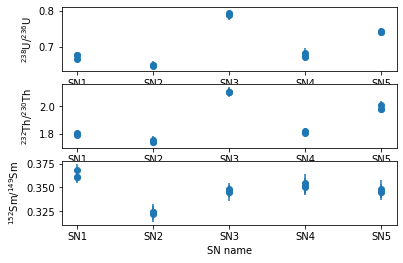

In [3]:
#spike normal ratio lists
SN_U_vals = []
SN_U_err = []
SN_Th_vals = [] 
SN_Th_err = []
SN_Sm_vals = []
SN_Sm_err = []
SN_names = []

#spike blank ratio lists
SB_U_vals = []
SB_U_err = []
SB_Th_vals = [] 
SB_Th_err = []
SB_Sm152_149_vals = []
SB_Sm152_149_err = []
SB_Sm154_152_vals = []
SB_Sm154_152_err = []
SB_Sm150_152_vals = []
SB_Sm150_152_err = []
SB_Sm148_152_vals = []
SB_Sm148_152_err = []
SB_Sm147_152_vals = []
SB_Sm147_152_err = []
SB_Sm144_152_vals = []
SB_Sm144_152_err = []

#sample ratio lists
sample_U_vals = []
sample_U_err = []
sample_Th_vals = []
sample_Th_err = []
sample_Sm_vals = []
sample_Sm_err = []
sample_names = []

#populate lists depending on aliquot type
#also report out the blanks values for 152, 232, and 238
for i in range(len(aliquot_list)):
    if aliquot_list[i].startswith('AB'):
        print('Blank levels for acid blank ',aliquot_list[i], ' are:\n',list_152intensity[i], ' for 152Sm, ',list_232intensity[i],' for 232Th, and ',list_238intensity[i],' for 238U\n')
    elif aliquot_list[i].startswith('Bomb') or aliquot_list[i].startswith('BB'):
        print('Blank levels for bomb blank ',aliquot_list[i],' are:\n',list_152intensity[i],' for 152Sm, ',list_232intensity[i],' for 232Th, and ',list_238intensity[i],' for 238U\n')
    elif aliquot_list[i].startswith('Empty') or aliquot_list[i].startswith('Blank'):
        print('Blank levels for Nb blank ',aliquot_list[i],' are:\n',list_152intensity[i],' for 152Sm, ',list_232intensity[i],' for 232Th, and ',list_238intensity[i],' for 238U\n')
    elif aliquot_list[i].startswith('SN'):
        SN_names.append(aliquot_list[i])
        SN_U_vals.append(float(list_238_236[i]))
        SN_U_err.append(float(list_238_236_1s[i]))
        SN_Th_vals.append(float(list_232_230[i]))
        SN_Th_err.append(float(list_232_230_1s[i]))
        SN_Sm_vals.append(float(list_152_149[i]))
        SN_Sm_err.append(float(list_152_149_1s[i]))
    elif aliquot_list[i].startswith('SBS'):
        SB_Sm152_149_vals.append(float(list_152_149[i]))
        SB_Sm152_149_err.append(float(list_152_149_1s[i]))
        SB_Sm154_152_vals.append(float(list_154_152[i]))
        SB_Sm154_152_err.append(float(list_154_152_1s[i]))
        SB_Sm150_152_vals.append(float(list_150_152[i]))
        SB_Sm150_152_err.append(float(list_150_152_1s[i]))
        SB_Sm148_152_vals.append(float(list_148_152[i]))
        SB_Sm148_152_err.append(float(list_148_152_1s[i]))
        SB_Sm147_152_vals.append(float(list_147_152[i]))
        SB_Sm147_152_err.append(float(list_147_152_1s[i]))
        SB_Sm144_152_vals.append(float(list_144_152[i]))
        SB_Sm144_152_err.append(float(list_144_152_1s[i]))
    elif aliquot_list[i].startswith('SBU'):
        SB_U_vals.append(float(list_238_236[i]))
        SB_U_err.append(float(list_238_236_1s[i]))
        SB_Th_vals.append(float(list_232_230[i]))
        SB_Th_err.append(float(list_232_230_1s[i]))
    else:
        sample_U_vals.append(float(list_238_236[i]))
        sample_U_err.append(float(list_238_236_1s[i]))
        sample_Th_vals.append(float(list_232_230[i]))
        sample_Th_err.append(float(list_232_230_1s[i]))
        sample_Sm_vals.append(float(list_152_149[i]))
        sample_Sm_err.append(float(list_152_149_1s[i]))
        sample_names.append(aliquot_list[i])
        
fig, axs = plt.subplots(3)

#this one plots 238/236
axs[0].set_xlabel('SN name')
axs[0].set_ylabel('$^{238}$U/$^{236}$U')

#this one plots 232/230
axs[1].set_xlabel('SN name')
axs[1].set_ylabel('$^{232}$Th/$^{230}$Th')

#this one plots 152/149
axs[2].set_xlabel('SN name')
axs[2].set_ylabel('$^{152}$Sm/$^{149}$Sm')

axs[0].errorbar(SN_names, SN_U_vals, SN_U_err, fmt='o')
axs[1].errorbar(SN_names, SN_Th_vals, SN_Th_err, fmt='o')
axs[2].errorbar(SN_names, SN_Sm_vals, SN_Sm_err, fmt='o')

plt.show()

The next cell below calculates the spike mass of U, Th, Sm, Zr, and Ca delivered to each of our samples using the spiked normal solutions as a reference. These values are assigned to the variables Sw_U, Sw_Th, Sw_Sm, Sw_Ca, and Sw_Zr that will be used in the next set of cells below this one. The fundamental equation for each element looks like this:

### $N_w = S_w * \frac{W_N}{W_S} * \frac{Ab_S^A - R_m*Ab_S^B}{R_m*Ab_N^B - Ab_N^A}$

which is rearranged to solve for $S_w$ such that:

### $S_w = N_w * \frac{W_S}{W_N} * \frac{R_m*Ab_N^B - Ab_N^A}{Ab_S^A - R_m*Ab_S^B}$

where: 
$N_w$ is the weight of the element in the normal solution,
$S_w$ is the weight of the element in the spike solution,
$W_N$ is the atomic weight of the element in the normal solution,
$W_S$ is the atomic weight of the element in the spike solution,
$Ab_S^A$ is the abundance of isotope A in the spike,
$Ab_S^B$ is the abundance of isotope B in the spike,
$Ab_N^A$ is the abundance of isotope A in the normal solution,
$Ab_N^B$ is the abundance of isotope B in the spike solution, and
$R_m$ is the measured ratio of the reference isotope over the enriched isotope. Each of these variables needs to have partial deriviatives calculated for error propagation, and this is also performed in the cell below.

In [4]:
#start with spike calibration: calculate the mass of each spike using the spiked normals as a reference standard

#function for weighted averages
def weight_avg(ratio_list, d_ratio_list):
    sum_W = 0
    sum_XW = 0
    
    for i in range(0,len(ratio_list)):
        W = 1/d_ratio_list[i]**2
        XW = W * ratio_list[i]
        sum_W = sum_W + W
        sum_XW = sum_XW + XW
    
    w_avg = sum_XW/sum_W
    w_avg_err = 1/math.sqrt(sum_W)
    
    return w_avg, w_avg_err

#function for calculating S_w
def spike_mass(Ab_A_nm, d_Ab_A_nm, Ab_B_nm, d_Ab_B_nm, Ab_A_spk, d_Ab_A_spk, Ab_B_spk, d_Ab_B_spk, Rm_spknm, d_Rm_spknm, Nw, d_Nw, Ws, d_Ws, Wn, d_Wn):
    
    #use some terms here for ease of doing error propagation: omega, gamma, kappa, zeta
    omega = Nw*Ws*1/Wn
    gamma = (Rm_spknm*Ab_B_nm - Ab_A_nm)/(Ab_A_spk - Rm_spknm*Ab_B_spk)
    kappa = Ab_A_spk - Rm_spknm*Ab_B_spk
    zeta = omega*Rm_spknm*Ab_B_nm - omega*Ab_A_nm
    
    #calculate all the partial derivatives for error propagation
    d_Sw_d_Nw = Ws * gamma/Wn
    d_Sw_d_Ws = Nw * gamma/Wn
    d_Sw_d_Wn = -omega * gamma/Wn
    d_Sw_d_Rm = (kappa*omega*Ab_B_nm + zeta*Ab_B_spk)/kappa**2
    d_Sw_d_Ab_A_nm = -omega/kappa
    d_Sw_d_Ab_B_nm = omega*Rm_spknm/kappa
    d_Sw_d_Ab_A_spk = -zeta/kappa**2
    d_Sw_d_Ab_B_spk = Rm_spknm*zeta/kappa
    
    #calculate Sw and d_Sw using terms above
    Sw = omega * gamma
    d_Sw = math.sqrt(d_Nw**2*d_Sw_d_Nw**2 + d_Ws**2*d_Sw_d_Ws**2 + d_Wn**2*d_Sw_d_Wn**2 + 
                     d_Rm_spknm**2*d_Sw_d_Rm**2 + d_Ab_B_nm**2*d_Sw_d_Ab_B_nm**2 + d_Ab_A_nm**2*d_Sw_d_Ab_A_nm**2 + 
                     d_Ab_B_spk**2*d_Sw_d_Ab_B_spk**2 + d_Ab_A_spk**2*d_Sw_d_Ab_A_spk**2)
    
    return Sw, d_Sw

#calculate mass of spike in each spike normal, SW_U, SW_Th, SW_Sm

#first up is U
#natural/spike ratio in spike blank used to get abundances of isotopes in the spike
Rs_U, d_Rs_U = weight_avg(SB_U_vals,SB_U_err)
Ab_236U_spk = 1/(1+Rs_U/137.818+Rs_U)
d_Ab_236U_spk = math.sqrt(d_Rs_U**2 * (-1*(1/137.818+1)/(1+Rs_U*(1/137.818+1))**2)**2)
Ab_238U_spk = (1-Ab_236U_spk)/(1+1/137.818)
d_Ab_238U_spk = math.sqrt(d_Ab_236U_spk**2 * (-1*1/(1+1/137.818))**2)
Ab_235U_spk = Ab_238U_spk/137.818
d_Ab_235U_spk = math.sqrt(d_Ab_238U_spk**2*(1/137.818)**2)

#atomic weight of U in spike (g/mol)
Ws_U = Ab_235U_spk*mass_235U + Ab_236U_spk*mass_236U + Ab_238U_spk*mass_238U
d_Ws_U = math.sqrt(d_Ab_235U_spk**2 * mass_235U**2 + d_Ab_236U_spk**2 * mass_236U**2 + d_Ab_238U_spk**2 * mass_238U**2)

#weight of U in the normal solution (ng)
Nw_U = Vnm_UTh*concnm_U
d_Nw_U = math.sqrt(d_Vnm_UTh**2*concnm_U**2 + d_concnm_U**2*Vnm_UTh**2)

#get weighted average of spike normals
Rm_spknm_U, d_Rm_spknm_U = weight_avg(SN_U_vals,SN_U_err)

#mass of U spike in each spike normal (ng), used in subsequent calculations for mass of U in unknowns 
Sw_U, d_Sw_U = spike_mass(Ab_238U_nm, d_Ab_238U_nm, 0, 0, Ab_238U_spk, d_Ab_238U_spk, Ab_236U_spk, d_Ab_236U_spk, 
                          Rm_spknm_U, d_Rm_spknm_U, Nw_U, d_Nw_U, Ws_U, d_Ws_U, mass_U, 0)


#next up is Th
#natural/spike ratio in spike blank used to get abundances of isotopes in the spike
Rs_Th, d_Rs_Th = weight_avg(SB_Th_vals,SB_Th_err)
Ab_230Th_spk = 1/(1+Rs_Th)
d_Ab_230Th_spk = math.sqrt(d_Rs_Th**2 * (-1/(1+Rs_Th)**2)**2)
Ab_232Th_spk = 1 - Ab_230Th_spk
d_Ab_232Th_spk = math.sqrt(d_Ab_230Th_spk**2 * 1**2)

#atomic weight of Th in spike (g/mol)
Ws_Th = Ab_230Th_spk*mass_230Th + Ab_232Th_spk*mass_232Th
d_Ws_Th = math.sqrt(d_Ab_230Th_spk**2 * mass_230Th**2 + d_Ab_232Th_spk**2 * mass_232Th**2)

#weight of Th in the normal solution (ng)
Nw_Th = Vnm_UTh*concnm_Th
d_Nw_Th = math.sqrt(d_Vnm_UTh**2*concnm_Th**2 + d_concnm_Th**2*Vnm_UTh**2)

#get weighted average of spike normals
Rm_spknm_Th, d_Rm_spknm_Th = weight_avg(SN_Th_vals,SN_Th_err)

#mass of Th spike in each spike normal (ng), used in subsequent calculations for mass of U in unknowns 
Sw_Th, d_Sw_Th = spike_mass(1, 0, 0, 0, Ab_232Th_spk, d_Ab_232Th_spk, Ab_230Th_spk, d_Ab_230Th_spk, 
                          Rm_spknm_Th, d_Rm_spknm_Th, Nw_Th, d_Nw_Th, Ws_Th, d_Ws_Th, mass_Th, 0)


#now we do Sm, but only if we're running apatites (not used for zircon)
#initial if statment checks if we actually spiked our normal solutions with 149Sm
#natural/spike ratio in spike blank used to get abundances of isotopes in the spike

if SB_Sm152_149_vals:
    Rs_Sm, d_Rs_Sm = weight_avg(SB_Sm152_149_vals,SB_Sm152_149_err)
    Rs_154_152, d_Rs_154_152 = weight_avg(SB_Sm154_152_vals,SB_Sm154_152_err)
    Rs_150_152, d_Rs_150_152 = weight_avg(SB_Sm150_152_vals,SB_Sm150_152_err)
    Rs_148_152, d_Rs_148_152 = weight_avg(SB_Sm148_152_vals,SB_Sm148_152_err)
    Rs_147_152, d_Rs_147_152 = weight_avg(SB_Sm147_152_vals,SB_Sm147_152_err)
    Rs_144_152, d_Rs_144_152 = weight_avg(SB_Sm144_152_vals,SB_Sm144_152_err)
    delta_Sm = 1 + Rs_154_152 + Rs_150_152 + Rs_148_152 + Rs_147_152 + Rs_144_152

    Ab_149Sm_spk = 1/(1 + Rs_Sm*delta_Sm)
    d_Ab_149Sm_spk = math.sqrt(d_Rs_Sm**2*(-delta_Sm/(1+Rs_Sm*delta_Sm)**2)**2 + 
                           d_Rs_144_152**2*(-Rs_Sm/(1+Rs_Sm*delta_Sm)**2)**2 + 
                           d_Rs_147_152**2*(-Rs_Sm/(1+Rs_Sm*delta_Sm)**2)**2 + 
                           d_Rs_148_152**2*(-Rs_Sm/(1+Rs_Sm*delta_Sm)**2)**2 + 
                           d_Rs_150_152**2*(-Rs_Sm/(1+Rs_Sm*delta_Sm)**2)**2 + 
                           d_Rs_154_152**2*(-Rs_Sm/(1+Rs_Sm*delta_Sm)**2)**2)
    Ab_152Sm_spk = Rs_Sm * Ab_149Sm_spk
    d_Ab_152Sm_spk = math.sqrt(d_Rs_Sm**2*Ab_149Sm_spk**2 + d_Ab_149Sm_spk**2*Rs_Sm**2)

    Ab_144Sm_spk = Ab_152Sm_spk*Rs_144_152
    d_Ab_144Sm_spk = math.sqrt(d_Rs_144_152**2*Ab_152Sm_spk**2 + d_Ab_152Sm_spk**2*Rs_144_152**2)
    Ab_147Sm_spk = Ab_152Sm_spk*Rs_147_152
    d_Ab_147Sm_spk = math.sqrt(d_Rs_147_152**2*Ab_152Sm_spk**2 + d_Ab_152Sm_spk**2*Rs_147_152**2)
    Ab_148Sm_spk = Ab_152Sm_spk*Rs_148_152
    d_Ab_148Sm_spk = math.sqrt(d_Rs_148_152**2*Ab_152Sm_spk**2 + d_Ab_152Sm_spk**2*Rs_148_152**2)
    Ab_150Sm_spk = Ab_152Sm_spk*Rs_150_152
    d_Ab_150Sm_spk = math.sqrt(d_Rs_150_152**2*Ab_152Sm_spk**2 + d_Ab_152Sm_spk**2*Rs_150_152**2)
    Ab_154Sm_spk = Ab_152Sm_spk*Rs_154_152
    d_Ab_154Sm_spk = math.sqrt(d_Rs_154_152**2*Ab_152Sm_spk**2 + d_Ab_152Sm_spk**2*Rs_154_152**2)

    #atomic weight of Sm in spike (g/mol)
    Ws_Sm = Ab_144Sm_spk*mass_144Sm + Ab_147Sm_spk*mass_147Sm + Ab_148Sm_spk*mass_148Sm + Ab_149Sm_spk*mass_149Sm + Ab_150Sm_spk*mass_150Sm + Ab_152Sm_spk*mass_152Sm + Ab_154Sm_spk*mass_154Sm
    d_Ws_Sm = math.sqrt(d_Ab_144Sm_spk**2*mass_144Sm**2 + d_Ab_147Sm_spk**2*mass_147Sm**2 + d_Ab_148Sm_spk**2*mass_148Sm**2 
                    + d_Ab_149Sm_spk**2*mass_149Sm**2 + d_Ab_150Sm_spk**2*mass_150Sm**2 + d_Ab_152Sm_spk**2*mass_152Sm**2 
                    + d_Ab_154Sm_spk**2*mass_154Sm**2)

    #weight of Sm in the normal solution (ng)
    Nw_Sm = Vnm_Sm*concnm_Sm
    d_Nw_Sm = math.sqrt(d_Vnm_Sm**2*concnm_Sm**2 + d_concnm_Sm**2*Vnm_Sm**2)

    #get weighted average of spike normals
    Rm_spknm_Sm, d_Rm_spknm_Sm = weight_avg(SN_Sm_vals,SN_Sm_err)

    #mass of Sm spike in each spike normal (ng), used in subsequent calculations for mass of U in unknowns 
    Sw_Sm, d_Sw_Sm = spike_mass(Ab_152Sm_nm, d_Ab_152Sm_nm, Ab_149Sm_nm, d_Ab_149Sm_nm, Ab_152Sm_spk, d_Ab_152Sm_spk, Ab_149Sm_spk, d_Ab_149Sm_spk, 
                          Rm_spknm_Sm, d_Rm_spknm_Sm, Nw_Sm, d_Nw_Sm, Ws_Sm, d_Ws_Sm, mass_Sm, 0)
else:
    Sw_Sm = 0
    d_Sw_Sm = 0

print('Masses of each spike in an aliquot are: {0:.5f} +/- {1:.5f} ng for U, {2:.5f} +/- {3:.5f} ng for Th, and {4:.5f} +/- {5:.5f} ng for Sm.'.format(Sw_U,d_Sw_U,Sw_Th,d_Sw_Th,Sw_Sm,d_Sw_Sm))


Masses of each spike in an aliquot are: 0.89679 +/- 0.00939 ng for U, 0.80164 +/- 0.00873 ng for Th, and 0.82246 +/- 0.00968 ng for Sm.


With our spike masses calibrated, we now use those spike masses to determine the mass of U, Th, and Sm in each unknown aliquot. The same fundamental equation is used:

### $Nw_U = Sw_U * \frac{Wn_U}{Ws_U} * \frac{Ab_S^A - R_m*Ab_S^B}{R_m*Ab_U^B - Ab_U^A}$

$Nw_U$ is the weight of the element (in this example U) in the unknown solution,
$Sw_U$ is the weight of the element in the spike solution,
$Wn_U$ is the atomic weight of the element in the unknown solution,
$Ws_U$ is the atomic weight of the element in the spike solution,
$Ab_S^A$ is the abundance of isotope A in the spike,
$Ab_S^B$ is the abundance of isotope B in the spike,
$Ab_U^A$ is the abundance of isotope A in the unknown solution,
$Ab_U^B$ is the abundance of isotope B in the unknown solution, and
$R_m$ is the measured ratio of the reference isotope over the enriched isotope. Each of these variables needs to have partial deriviatives calculated for error propagation, and this is also performed in the cell below. To simplify this math, once again we define:

### $\omega_U = Sw_U * \frac{Wn_U}{Ws_U}$
and
### $\gamma_U = \frac{Ab_S^A - R_m*Ab_S^B}{R_m*Ab_U^B - Ab_U^A}$

In [5]:
#function for calculating Nw_element
def aliquot_mass(Ab_A_el, d_Ab_A_el, Ab_B_el, d_Ab_B_el, Ab_A_spk, d_Ab_A_spk, Ab_B_spk, d_Ab_B_spk, Rm_el, d_Rm_el, Sw, d_Sw, Ws, d_Ws, Wn, d_Wn):
    
    #use some terms here for ease of doing error propagation: omega, gamma, kappa, zeta
    omega = Sw*Wn/Ws
    gamma = (Ab_A_spk - Rm_el*Ab_B_spk)/(Rm_el*Ab_B_el - Ab_A_el)
    kappa = Rm_el*Ab_B_el - Ab_A_el
    zeta = omega*Ab_A_spk - omega*Rm_el*Ab_B_spk
    
    #calculate all the partial derivatives for error propagation
    d_Nw_d_Sw = Wn * gamma/Ws
    d_Nw_d_Ws = -omega*gamma/Ws
    d_Nw_d_Wn = Sw * gamma/Ws
    d_Nw_d_Rm = (-omega*Ab_B_spk*kappa - zeta*Ab_B_el)/kappa**2
    d_Nw_d_Ab_A_el = -Rm_el*zeta/kappa**2
    d_Nw_d_Ab_B_el = zeta/kappa**2
    d_Nw_d_Ab_A_spk = omega/kappa
    d_Nw_d_Ab_B_spk = -Rm_el*omega/kappa
    
    #calculate Sw and d_Sw using terms above
    Nw = omega * gamma
    d_Nw = math.sqrt(d_Sw**2*d_Nw_d_Sw**2 + d_Ws**2*d_Nw_d_Ws**2 + d_Wn**2*d_Nw_d_Wn**2 + 
                     d_Rm_el**2*d_Nw_d_Rm**2 + d_Ab_B_el**2*d_Nw_d_Ab_B_el**2 + d_Ab_A_el**2*d_Nw_d_Ab_A_el**2 + 
                     d_Ab_B_spk**2*d_Nw_d_Ab_B_spk**2 + d_Ab_A_spk**2*d_Nw_d_Ab_A_spk**2)
    
    return Nw, d_Nw

#calculate U, Th, and Sm mass (ng) for each sample, add to sample mass lists
sample_U_mass = []
sample_U_mass_1s = []
sample_238U_mol =[]
sample_238U_mol_1s = []
sample_235U_mol = []
sample_235U_mol_1s = []
sample_Th_mass = []
sample_Th_mass_1s = []
sample_Th_mol = []
sample_Th_mol_1s = []
sample_Sm_mass = []
sample_Sm_mass_1s = []
sample_Sm_mol = []
sample_Sm_mol_1s = []


for i in range(len(sample_names)):
    U_mass, U_mass_1s = aliquot_mass(Ab_238U_nm, d_Ab_238U_nm, 0, 0, Ab_238U_spk, d_Ab_238U_spk, Ab_236U_spk, d_Ab_236U_spk, 
                                     sample_U_vals[i], sample_U_err[i], Sw_U, d_Sw_U, Ws_U, d_Ws_U, mass_U, 0)
    sample_U_mass.append(U_mass)
    sample_U_mass_1s.append(U_mass_1s)
    sample_238U_mol.append(U_mass * 1e-9 * 1/mass_U*Ab_238U_nm)
    sample_238U_mol_1s.append(U_mass_1s * 1e-9 * 1/mass_U*Ab_238U_nm)
    sample_235U_mol.append(U_mass * 1e-9 * 1/mass_U*Ab_235U_nm)
    sample_235U_mol_1s.append(U_mass_1s * 1e-9 * 1/mass_U*Ab_235U_nm)
    
    Th_mass, Th_mass_1s = aliquot_mass(1, 0, 0, 0, Ab_232Th_spk, d_Ab_232Th_spk, Ab_230Th_spk, d_Ab_230Th_spk, 
                                     sample_Th_vals[i], sample_Th_err[i], Sw_Th, d_Sw_Th, Ws_Th, d_Ws_Th, mass_Th, 0)
    sample_Th_mass.append(Th_mass)
    sample_Th_mass_1s.append(Th_mass_1s)
    sample_Th_mol.append(Th_mass * 1e-9 * 1/(mass_Th))
    sample_Th_mol_1s.append(Th_mass_1s * 1e-9 * 1/(mass_Th))
    
    if SB_Sm152_149_vals:
        Sm_mass, Sm_mass_1s = aliquot_mass(Ab_152Sm_nm, d_Ab_152Sm_nm, Ab_149Sm_nm, d_Ab_149Sm_nm, Ab_152Sm_spk, d_Ab_152Sm_spk, Ab_149Sm_spk, d_Ab_149Sm_spk, 
                                     sample_Sm_vals[i], sample_Sm_err[i], Sw_Sm, d_Sw_Sm, Ws_Sm, d_Ws_Sm, mass_Sm, 0)
        sample_Sm_mass.append(Sm_mass)
        sample_Sm_mass_1s.append(Sm_mass_1s)
        sample_Sm_mol.append(Sm_mass * 1e-9 * 1/mass_Sm*Ab_147Sm_nm)
        sample_Sm_mol_1s.append(Th_mass_1s * 1e-9 * 1/mass_Sm*Ab_147Sm_nm)
    else:
        sample_Sm_mass.append(0)
        sample_Sm_mass_1s.append(0)
        sample_Sm_mol.append(0)
        sample_Sm_mol_1s.append(0)
    

The next cell below brings in the line summary json and calculates the uncorrected date for each sample. The age equation, which can't be solved for t using algebra, has the form:

### $^{4}He_{mol} = 8 * ^{238}U_{mol}(\exp(\lambda_{238} * t) - 1) + 7 * ^{235}U_{mol}(\exp(\lambda_{235} * t) - 1) + 6 * ^{232}Th_{mol}(\exp(\lambda_{232} * t) - 1) + ^{147}Sm_{mol}(\exp(\lambda_{147} * t) - 1)$

We use a Newton-Raphson method for determine date, where:

### $t_1 = t_0 - \frac{f(t_0)}{f'(t_0)}$

### $f(t_0) = 8 * ^{238}U_{mol}(\exp(\lambda_{238} * t) - 1) + 7 * ^{235}U_{mol}(\exp(\lambda_{235} * t) - 1) + 6 * ^{232}Th_{mol}(\exp(\lambda_{232} * t) - 1) + ^{147}Sm_{mol}(\exp(\lambda_{147} * t) - 1) - ^{4}He_{mol}$

and 

### $f'(t_0) = 8 * ^{238}U_{mol} * \lambda_{238} * \exp(\lambda_{238} * t) + 7 * ^{235}U_{mol} * \lambda_{235} * \exp(\lambda_{238} * t) + 6 * ^{232}Th_{mol} * \lambda_{232} * \exp(\lambda_{232} * t) + ^{147}Sm_{mol} * \lambda_{147} * \exp(\lambda_{147} * t)$

The error is solved by taking the partial derivatives of terms within an approximation of the age equation using the second term of the Taylor Series expansion. This is a pretty dang good approximation as it gets the error value within less than 1% of the "true" value. That equation looks like:

## $ t = \frac{^{4}He_{mol}}{8 * ^{238}U_{mol} * \lambda_{238} + 7 * ^{235}U_{mol} * \lambda_{235} + 6 * ^{232}Th_{mol} * \lambda_{232} + ^{147}Sm_{mol} * \lambda_{147}}$

In [6]:
#line summary json file
He_file = project + '_He_data.json'

with open(He_file, 'r') as j_file:
     He_data = json.loads(j_file.read())

#lists of He data 
sample_He_vol = []
sample_He_vol_1s = []
sample_He_mol = []
sample_He_mol_1s = []
sample_He_notes = []
sample_type = []

#sample uncorrected date and error list
sample_uncorrected_date = []
sample_uncorrected_date_1s= []

for index in sample_names:
    sample_He_vol.append(He_data[index][0])
    sample_He_vol_1s.append(He_data[index][1])
    sample_He_mol.append(He_data[index][2])
    sample_He_mol_1s.append(He_data[index][3])
    sample_He_notes.append(He_data[index][4])
    sample_type.append(He_data[index][5])

for index in range(len(sample_names)):
    
    #this is here because there could be cases where apatites and zircons are run in the same ICP-MS routine
    if sample_type[index] == 'zirc':
        sample_Sm_mol[index] = 0
        sample_Sm_mol_1s[index] = 0
        sample_Sm_mol.append(0)
        sample_Sm_mol_1s.append(0)
    
    #calculate uncorrected dates using Newton-Raphson method, get the guess to the 1 year precision
    tolerance = 1
    date_guess = 5e7
    uncorrected_date = 0
    f_date = 8*sample_238U_mol[index]*(math.exp(lambda_238*date_guess) - 1) + 7*sample_235U_mol[index]*(math.exp(lambda_235*date_guess) - 1) + 6*sample_Th_mol[index]*(math.exp(lambda_232*date_guess) - 1) + sample_Sm_mol[index]*(math.exp(lambda_147*date_guess) - 1) - sample_He_mol[index]
    f_date_prime = 8*sample_238U_mol[index]*lambda_238*math.exp(lambda_238*date_guess)  + 7*sample_235U_mol[index]*lambda_235*math.exp(lambda_235*date_guess) + 6*sample_Th_mol[index]*lambda_232*math.exp(lambda_232*date_guess) + sample_Sm_mol[index]*lambda_147*math.exp(lambda_147*date_guess)
    date_diff = date_guess
    
    while abs(date_diff) > tolerance:
        uncorrected_date = date_guess - f_date/f_date_prime
        date_diff = date_guess - uncorrected_date
        date_guess = uncorrected_date
        f_date = 8*sample_238U_mol[index]*(math.exp(lambda_238*date_guess) - 1) + 7*sample_235U_mol[index]*(math.exp(lambda_235*date_guess) - 1) + 6*sample_Th_mol[index]*(math.exp(lambda_232*date_guess) - 1) + sample_Sm_mol[index]*(math.exp(lambda_147*date_guess) - 1) - sample_He_mol[index]
        f_date_prime = 8*sample_238U_mol[index]*lambda_238*math.exp(lambda_238*date_guess)  + 7*sample_235U_mol[index]*lambda_235*math.exp(lambda_235*date_guess) + 6*sample_Th_mol[index]*lambda_232*math.exp(lambda_232*date_guess) + sample_Sm_mol[index]*lambda_147*math.exp(lambda_147*date_guess)
        
    sample_uncorrected_date.append(uncorrected_date/1e6)
    
    #calculate uncorrected date error using the 2nd term in Taylor Series of age equation
    alpha = 8*sample_238U_mol[index]*lambda_238 + 7*sample_235U_mol[index]*lambda_235 + 6*sample_Th_mol[index]*lambda_232 + sample_Sm_mol[index]*lambda_147
    
    d_t_d_4He = 1/alpha
    d_t_d_238U = (-sample_He_mol[index]*8*lambda_238)/alpha**2
    d_t_d_235U = (-sample_He_mol[index]*7*lambda_235)/alpha**2
    d_t_d_232Th = (-sample_He_mol[index]*6*lambda_232)/alpha**2
    d_t_d_147Sm = (-sample_He_mol[index]*lambda_147)/alpha**2
    
    uncorrected_date_1s = math.sqrt(d_t_d_4He**2 * sample_He_mol_1s[index]**2 + 
                                    d_t_d_238U**2 * sample_238U_mol_1s[index]**2 + 
                                    d_t_d_235U**2 * sample_235U_mol_1s[index]**2 + 
                                    d_t_d_232Th**2 * sample_Th_mol_1s[index]**2 + 
                                    d_t_d_147Sm**2 * sample_Sm_mol_1s[index]**2)
    
    sample_uncorrected_date_1s.append(uncorrected_date_1s/1e6)

Below we bring in Ft data for each sample. Two Ft methods are used here. We follow the equations from Farley, 2002:

### $F_{t} = 1 + a_{1}\beta + a_{2}\beta^{2}$

### $^{Mean}F_{t} = a_{238} * ^{^{238}U}F_{t} + (1 - a_{238}) * ^{^{232}Th}F_{t}$

### $a_{238} = (1.04 + 0.245(Th/U))^{-1}$

where $a_{1}$ and $a_{2}$ are U and Th specific constants listed in Farley (2002) Table 1 and set in the first cell of this notebook. $\beta$ is the surface area to volume ratio, which for a hexagonal prism (apatite) is given by:

### $\beta = \frac{2.31L + 2R}{RL}$

where $L$ is the length and $R$ is the half-width of the grain. For zircon grains, we follow the equations described in Reiners et al. (2005, AJS) and Hourigan et al. (2005), with $a_{1}$ and $a_{2}$ values listed in Farley (2002) Table 1. Two equations are used, depending upon the degree of abrasion: tetragonal prism with pyramidal terminations ($z$, abrasion index 1-3), or prolate spheroid ($ps$, abrasion index 4-5). The basic $F_{t}$ equation has the same form as the Farley (2002) equation used above. However, the equation for $\beta$ is different. For the tetragonal prism $\beta$, the equations are (where $SA$ is surface area and $V$ is volume):

### $SA_{z} = 4(l - h_{1} - h_{2})(r_{1} + r_{2}) + 2r_{1}a + 2r_{2}b$

### $V_{z} = 4r_{1}r_{2}[(l - h_{1} - h_{2}) + \frac{1}{3}(h_{1} + h_{2})]$

where $l$ is grain length, $r_1$ and $r_2$ are prism half-widths, $h_1$ and $h_2$ are pyramidal termination heights, and $a$ and $b$ are related to the slant heights of the terminations as determined by:

### $a = \sqrt{h_{1}^{2} + r_{2}^{2}} + \sqrt{h_{2}^{2} + r_{2}^{2}}$

### $b = \sqrt{h_{1}^{2} + r_{1}^{2}} + \sqrt{h_{2}^{2} + r_{1}^{2}}$

For the prolate spheroid case, the $\beta$ equations are (NOTE: Reiners et al. (2005, AJS) has a number of typos in the reported equations. I have fixed these below by adding a ^2 to the appropriate l/2 terms):

### $SA_{ps} = 2\pi{}r^{2} + \frac{2\pi{}r(l/2)^{2}}{\sqrt{(l/2)^{2} - r^{2}}}\sin^{-1}[\frac{\sqrt{(l/2)^{2} - r^{2}}}{(l/2)}]$

### $V_{ps} = \frac{2}{3}\pi{}r^{2}l$


In [7]:
#lists for Ft data
Ft238U_list = []
Ft235U_list = []
FtTh_list = []
FtSm_list = []
Ft_list = []
morph_note_list = []
Equiv_rad_list = []
grain_mass_morph_list = []

#csv file for Ft data
Ft_file = project + '_Ft_data.csv'

#load the Ft data into a dictionary to look up by sample name
with open(Ft_file, 'r', newline = '') as Ft_in_file:
    csv_reader_Ft = csv.reader(Ft_in_file)
    
    #throw away the first 8 lines
    for i in range(8):
        next(csv_reader_Ft)
    
    #fill in Ft dictionary, indexed by sample name
    Ft_dict = {}
    for line in csv_reader_Ft:
        #sometimes there might be blank rows separating Ft data
        if line:
            Ft_dict[line[0]] = line[1:]

#for loop through the sample names and calculate Ft for ap or zirc (z or ps)

for i in range(len(sample_names)):    
    Ft_sample_name =  sample_names[i]
    morph_note_list.append(Ft_dict[Ft_sample_name][0])
    
    A_238 = 1/(1.04 + 0.245*(sample_Th_mol[i]/(sample_238U_mol[i]+sample_235U_mol[i])))
    
    if sample_type[i] == 'ap':       
        if Ft_dict[Ft_sample_name][1] == 'DUR' or Ft_dict[Ft_sample_name][1] == 'dur':
            Ft238U_list.append(1)
            Ft235U_list.append(1)
            FtTh_list.append(1)
            FtSm_list.append(1)
            Ft_list.append(1)
            Equiv_rad_list.append('NaN')
            grain_mass_morph_list.append('NaN')
        
        else:
            broken = float(Ft_dict[Ft_sample_name][1])   
            
            grain_length_avg = (float(Ft_dict[Ft_sample_name][2]) + float(Ft_dict[Ft_sample_name][3]))/2
            grain_radius = ((float(Ft_dict[Ft_sample_name][4]) + float(Ft_dict[Ft_sample_name][5]))/2)/2
            beta_ap = (2.31*grain_length_avg*broken + 2*grain_radius)/(broken*grain_length_avg*grain_radius)
            
            Ft238U_list.append(1 + a1_238U_ap*beta_ap + a2_238U_ap*beta_ap**2)
            Ft235U_list.append(1 + a1_235U_ap*beta_ap + a2_235U_ap*beta_ap**2)
            FtTh_list.append(1 + a1_Th_ap*beta_ap + a2_Th_ap*beta_ap**2)
            FtSm_list.append(-0.09158*Ft238U_list[i]**2 + 0.46974*Ft238U_list[i] + 0.61895)
            Ft_list.append(A_238*Ft238U_list[i] + (1-A_238)*FtTh_list[i])
            
            Equiv_rad_list.append(3/beta_ap)
            grain_volume = 2.598*grain_radius**2*grain_length_avg*1e-12 #in cc   
            grain_mass_morph_list.append(grain_volume * ap_density) #in g
            
    elif sample_type[i] == 'zirc':
            abrasion = float(Ft_dict[Ft_sample_name][1])
            grain_length_avg = (float(Ft_dict[Ft_sample_name][2]) + float(Ft_dict[Ft_sample_name][3]))/2
            grain_radius_1 = float(Ft_dict[Ft_sample_name][4])/2
            grain_radius_2 = float(Ft_dict[Ft_sample_name][5])/2
            grain_width_avg = (float(Ft_dict[Ft_sample_name][4]) + float(Ft_dict[Ft_sample_name][5]))/2
            
            # there could be cases for very rounded grains where what's a length vs. a width is not apparent
            # this if statement ensures (so that the SA_ps math works) that the length is ALWAYS the longest dimension
            if grain_width_avg > grain_length_avg:
                grain_length_avg_old = grain_length_avg
                grain_length_avg = grain_width_avg
                grain_width_avg = grain_length_avg_old
            
            grain_radius_avg = grain_width_avg/2
            
            if abrasion <= 3:
                a_z = math.sqrt(float(Ft_dict[Ft_sample_name][6])**2 + grain_radius_2**2) + math.sqrt(float(Ft_dict[Ft_sample_name][7])**2 + grain_radius_2**2)
                b_z = math.sqrt(float(Ft_dict[Ft_sample_name][6])**2 + grain_radius_1**2) + math.sqrt(float(Ft_dict[Ft_sample_name][7])**2 + grain_radius_1**2)
                SA_z = 4*(grain_length_avg - float(Ft_dict[Ft_sample_name][6]) - float(Ft_dict[Ft_sample_name][7]))*(grain_radius_1 + grain_radius_2) + 2*grain_radius_1*a_z + 2*grain_radius_2*b_z
                grain_volume = 4*grain_radius_1*grain_radius_2*((grain_length_avg - float(Ft_dict[Ft_sample_name][6]) - float(Ft_dict[Ft_sample_name][7])) + (1/3)*(float(Ft_dict[Ft_sample_name][6]) + float(Ft_dict[Ft_sample_name][7])))  
                beta_z = SA_z/grain_volume
            
                Ft238U_list.append(1 + a1_238U_zirc*beta_z + a2_238U_zirc*beta_z**2)
                Ft235U_list.append(1 + a1_235U_zirc*beta_z + a2_235U_zirc*beta_z**2)
                FtTh_list.append(1 + a1_Th_zirc*beta_z + a2_Th_zirc*beta_z**2)
                FtSm_list.append(1)
                Ft_list.append(A_238*Ft238U_list[i] + (1-A_238)*FtTh_list[i])
            
                Equiv_rad_list.append(3/beta_z)   
                grain_mass_morph_list.append(grain_volume*1e-12 * zirc_density) #in g
            else:
                SA_ps = 2*math.pi*grain_radius_avg**2 + ((2*math.pi*grain_radius_avg*(grain_length_avg/2)**2)/(math.sqrt((grain_length_avg/2)**2 - grain_radius_avg**2)))*math.asin(math.sqrt((grain_length_avg/2)**2 - grain_radius_avg**2)/(grain_length_avg/2))
                grain_volume = (2/3)*math.pi*grain_radius_avg**2*grain_length_avg
                beta_ps = SA_ps/grain_volume
            
                Ft238U_list.append(1 + a1_238U_zirc*beta_ps + a2_238U_zirc*beta_ps**2)
                Ft235U_list.append(1 + a1_235U_zirc*beta_ps + a2_235U_zirc*beta_ps**2)
                FtTh_list.append(1 + a1_Th_zirc*beta_ps + a2_Th_zirc*beta_ps**2)
                FtSm_list.append(1)
                Ft_list.append(A_238*Ft238U_list[i] + (1-A_238)*FtTh_list[i])
            
                Equiv_rad_list.append(3/beta_ps)   
                grain_mass_morph_list.append(grain_volume*1e-12 * zirc_density) #in g


Below we use the Ft corrections on each of the parent isotopes and then solve for the corrected dates using the Newton-Raphson method as above.

In [8]:
#sample corrected date and error list
sample_corrected_date = []
sample_corrected_date_1s= []

for index in range(len(sample_names)):
    
    #calculate corrected dates using Newton-Raphson method, get the guess to the 1 year precision
    tolerance = 1
    date_guess = 5e7
    uncorrected_date = 0
    Ft_238U = sample_238U_mol[index] * Ft238U_list[index]
    Ft_238U_1s = sample_238U_mol_1s[index] * Ft238U_list[index]
    Ft_235U = sample_235U_mol[index] * Ft235U_list[index]
    Ft_235U_1s = sample_235U_mol_1s[index] * Ft235U_list[index]
    Ft_Th = sample_Th_mol[index] * FtTh_list[index]
    Ft_Th_1s = sample_Th_mol_1s[index] * FtTh_list[index]
    Ft_Sm = sample_Sm_mol[index] * FtSm_list[index]
    Ft_Sm_1s = sample_Sm_mol_1s[index] * FtSm_list[index]
    
    f_date = 8*Ft_238U*(math.exp(lambda_238*date_guess) - 1) + 7*Ft_235U*(math.exp(lambda_235*date_guess) - 1) + 6*Ft_Th*(math.exp(lambda_232*date_guess) - 1) + Ft_Sm*(math.exp(lambda_147*date_guess) - 1) - sample_He_mol[index]
    f_date_prime = 8*Ft_238U*lambda_238*math.exp(lambda_238*date_guess)  + 7*Ft_235U*lambda_235*math.exp(lambda_235*date_guess) + 6*Ft_Th*lambda_232*math.exp(lambda_232*date_guess) + Ft_Sm*lambda_147*math.exp(lambda_147*date_guess)
    date_diff = date_guess
    
    while abs(date_diff) > tolerance:
        corrected_date = date_guess - f_date/f_date_prime
        date_diff = date_guess - corrected_date
        date_guess = corrected_date
        f_date = 8*Ft_238U*(math.exp(lambda_238*date_guess) - 1) + 7*Ft_235U*(math.exp(lambda_235*date_guess) - 1) + 6*Ft_Th*(math.exp(lambda_232*date_guess) - 1) + Ft_Sm*(math.exp(lambda_147*date_guess) - 1) - sample_He_mol[index]
        f_date_prime = 8*Ft_238U*lambda_238*math.exp(lambda_238*date_guess)  + 7*Ft_235U*lambda_235*math.exp(lambda_235*date_guess) + 6*Ft_Th*lambda_232*math.exp(lambda_232*date_guess) + Ft_Sm*lambda_147*math.exp(lambda_147*date_guess)
    
    sample_corrected_date.append(corrected_date/1e6)
    
    #calculate corrected date error using the 2nd term in Taylor Series of age equation
    alpha = 8*Ft_238U*lambda_238 + 7*Ft_235U*lambda_235 + 6*Ft_Th*lambda_232 + Ft_Sm*lambda_147
    
    d_t_d_4He = 1/alpha
    d_t_d_238U = (-sample_He_mol[index]*8*lambda_238)/alpha**2
    d_t_d_235U = (-sample_He_mol[index]*7*lambda_235)/alpha**2
    d_t_d_232Th = (-sample_He_mol[index]*6*lambda_232)/alpha**2
    d_t_d_147Sm = (-sample_He_mol[index]*lambda_147)/alpha**2
    
    corrected_date_1s = math.sqrt(d_t_d_4He**2 * sample_He_mol_1s[index]**2 + 
                                    d_t_d_238U**2 * Ft_238U_1s**2 + 
                                    d_t_d_235U**2 * Ft_235U_1s**2 + 
                                    d_t_d_232Th**2 * Ft_Th_1s**2 + 
                                    d_t_d_147Sm**2 * Ft_Sm_1s**2)
    
    sample_corrected_date_1s.append(corrected_date_1s/1e6)

The final step is to combine the various lists into a report that is exported to a csv file. The data lists are combined into a data frame to accomplish this task.

In [9]:
#create the sample data frame
sample_frame = pd.DataFrame(columns = ['analysis_notes','morph_notes','corrected_date','corrected_1s','corrected_1s_%','radius',
                                       'Ft','uncorrected_date','uncorrected_1s','uncorrected_1s_%','U_ng','U_ng_1s','U_ng_1s_%',
                                       'Th_ng','Th_ng_1s','Th_ng_1s_%','Sm_ng','Sm_ng_1s','Sm_ng_1s_%','He_pmol','He_pmol_1s','He_pmol_1s_%',
                                       'mass_morph_g','U_ppm','Th_ppm','Sm_ppm','eU'], index = [])

#fill in the frame
for i in range(len(sample_names)):
    
    He_pmol = sample_He_mol[i] * 1e12
    He_pmol_1s = sample_He_mol_1s[i] * 1e12
    
    if Ft_dict[sample_names[i]][1] == 'DUR' or Ft_dict[sample_names[i]][1] == 'dur':
        U_ppm = 0
        Th_ppm = 0
        Sm_ppm = 0
        eU = 0
    else:
        U_ppm = (sample_U_mass[i]*1e-3)/grain_mass_morph_list[i]
        Th_ppm = (sample_Th_mass[i]*1e-3)/grain_mass_morph_list[i]
        Sm_ppm = (sample_Sm_mass[i]*1e-3)/grain_mass_morph_list[i]
        eU = U_ppm + 0.235*Th_ppm
    
    #for zircons, need to make sure not to attempt a divide by zero for Sm % error
    if Sm_ppm > 0:
        Sm_ng_1s_rel = 100*(sample_Sm_mass_1s[i]/sample_Sm_mass[i])
    else:
        Sm_ng_1s_rel = 0

    row_data = pd.DataFrame({'analysis_notes':sample_He_notes[i],'morph_notes':morph_note_list[i],
                            'corrected_date':sample_corrected_date[i],'corrected_1s':sample_corrected_date_1s[i],
                            'corrected_1s_%':100*(sample_corrected_date_1s[i]/sample_corrected_date[i]),
                            'radius':Equiv_rad_list[i],'Ft':Ft_list[i],'uncorrected_date':sample_uncorrected_date[i],
                            'uncorrected_1s':sample_uncorrected_date_1s[i],'uncorrected_1s_%':100*(sample_uncorrected_date_1s[i]/sample_uncorrected_date[i]),
                            'U_ng':sample_U_mass[i],'U_ng_1s':sample_U_mass_1s[i], 'U_ng_1s_%':100*(sample_U_mass_1s[i]/sample_U_mass[i]),
                            'Th_ng':sample_Th_mass[i],'Th_ng_1s':sample_Th_mass_1s[i], 'Th_ng_1s_%':100*(sample_Th_mass_1s[i]/sample_Th_mass[i]), 
                            'Sm_ng':sample_Sm_mass[i], 'Sm_ng_1s':sample_Sm_mass_1s[i], 'Sm_ng_1s_%':Sm_ng_1s_rel,
                            'He_pmol':He_pmol,'He_pmol_1s':He_pmol_1s, 'He_pmol_1s_%':100*(He_pmol_1s/He_pmol),
                            'mass_morph_g':grain_mass_morph_list[i],'U_ppm':U_ppm,'Th_ppm':Th_ppm,'Sm_ppm':Sm_ppm,'eU':eU}, 
                            columns = ['analysis_notes','morph_notes','corrected_date','corrected_1s','corrected_1s_%','radius',
                                       'Ft','uncorrected_date','uncorrected_1s','uncorrected_1s_%','U_ng','U_ng_1s','U_ng_1s_%','Th_ng','Th_ng_1s',
                                       'Th_ng_1s_%', 'Sm_ng','Sm_ng_1s','Sm_ng_1s_%','He_pmol','He_pmol_1s','He_pmol_1s_%','mass_morph_g','U_ppm','Th_ppm',
                                       'Sm_ppm','eU'], index = [sample_names[i]])
    sample_frame = pd.concat([sample_frame, row_data])
    
sample_frame.to_csv(project + '_' + str(bomb_run) + '_report.csv')

display(sample_frame)

,analysis_notes,morph_notes,corrected_date,corrected_1s,corrected_1s_%,radius,Ft,uncorrected_date,uncorrected_1s,uncorrected_1s_%,U_ng,U_ng_1s,...,Th_ng_1s_%,Sm_ng,Sm_ng_1s,Sm_ng_1s_%,He_pmol,He_pmol_1s,He_pmol_1s_%,mass_morph_g,U_ppm,Th_ppm,Sm_ppm,eU
Durango_G,NaN,,39.657320,1.495717,3.771604,NaN,1,39.657320,1.495717,3.771604,0.010415,0.000592,...,4.370118,0.149538,0.003483,0,0.010422,0.000110,1.058319,NaN,0,0,0,0
THERMO_08A,NaN,"Whole grain with no breakage, no visible inclu...",89.868869,2.639985,2.937597,64.2894,0.768448,69.215683,2.023250,2.923110,0.055396,0.001847,...,5.062637,0.137995,0.007567,5.48388,0.025667,0.000230,0.898012,7.08065e-06,7.82363,7.67212,19.489,9.62658
THERMO_08B,NaN,"Whole grain with little breakage in one edge, ...",98.509185,3.611211,3.665862,58.5015,0.746832,73.775487,2.713767,3.678413,0.031795,0.001180,...,10.350694,0.101051,0.009495,9.39595,0.015975,0.000156,0.979414,5.4026e-06,5.88506,6.27234,18.7041,7.35906
THERMO_08C,NaN,"Whole grain, no visible inclusions, no abratio...",73.062022,3.294238,4.508824,43.6709,0.670653,49.129219,2.226470,4.531866,0.023480,0.001070,...,14.142779,0.040739,0.004946,12.1398,0.007586,0.000083,1.096354,2.82539e-06,8.31032,7.48721,14.4187,10.0698
THERMO_08D,NaN,"Whole grain, breakage in one edge, no visible ...",120.751240,5.525406,4.575859,43.6224,0.67081,81.312681,3.748850,4.610412,0.025838,0.001140,...,16.642182,0.036089,0.005023,13.9192,0.013655,0.000133,0.977318,2.80083e-06,9.22515,7.64897,12.8851,11.0227
THERMO_08E,NaN,"Broken grain, one edge of the grain is broken,...",668.050376,332.723039,49.805082,41.1532,0.64528,439.305405,222.856779,50.729351,0.000805,0.000231,...,131.592008,0.003870,0.003554,91.821,0.003033,0.000035,1.139807,1.86392e-06,0.432014,0.976124,2.07649,0.661404
THERMO_08F,NaN,"Whole grain, no visible inclusions, intermedia...",102.928036,3.654678,3.550712,52.5143,0.719636,74.313009,2.694075,3.625307,0.023715,0.000580,...,13.235373,0.084219,0.005563,6.60592,0.012338,0.000122,0.989550,3.83581e-06,6.18245,7.49568,21.956,7.94394
ZBTH23_03A,NaN,Euhedral with both rounded tips present. Surfa...,114.838975,13.119367,11.424142,39.2554,0.635321,73.719296,8.725031,11.835478,0.005254,0.000454,...,42.750392,0.104196,0.005780,5.54723,0.002788,0.000049,1.773678,1.71525e-06,3.06324,3.93423,60.7471,3.98778
Durango_H,NaN,,35.739528,0.649113,1.816233,NaN,1,35.739528,0.649113,1.816233,0.036263,0.001975,...,1.576551,0.564559,0.015461,0,0.037840,0.000320,0.846135,NaN,0,0,0,0
ZBTH23_03B,NaN,Euhedral but one termination broken off. Small...,87.517287,6.575686,7.513585,36.7192,0.608254,53.600639,4.103379,7.655466,0.008918,0.000677,...,17.100623,0.108643,0.006011,5.53265,0.003966,0.000056,1.403660,1.0986e-06,8.11741,17.7745,98.8922,12.2944
